# DLAV Project - Phase 3

In this notebook we will train a very simple planner and test its real-world performance.


The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
!pip install -q safetensors

# Standard libs
import os
import zipfile
import pickle
import random
import heapq

# Third-party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import transforms
import gdown
from scipy.signal import savgol_filter
from torchvision.transforms import v2

from safetensors import safe_open
from safetensors.torch import save_file, load_file

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=6b7711dd-0ddf-453b-829a-572962f69517
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/dlav_train.zip
100%|██████████| 439M/439M [00:43<00:00, 10.0MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=d312eaa0-2a9c-4160-ba21-65b89bf52eac
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/dlav_val_real.zip
100%|██████████| 129M/129M [00:14<00:00, 8.68MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=f53f66ce-9a98-4571-8c26-81f77f9d54fb
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/test_public_re

Now lets load the data and visualize how the real data looks like!

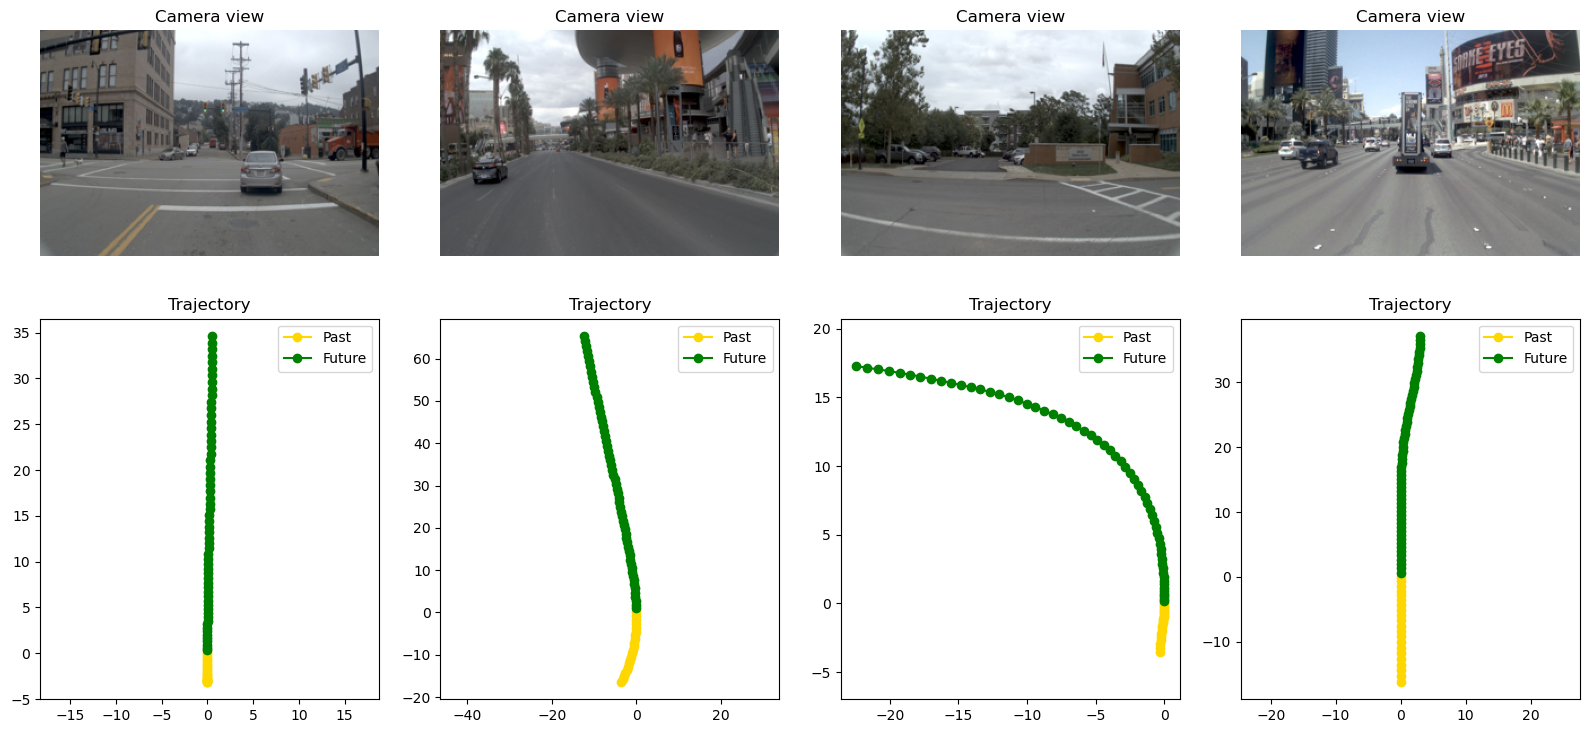

In [5]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"val_real/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(2, k, figsize=(4*k, 8))
for i in range(k):
    axis[0, i].imshow(data[i]["camera"])
    axis[0, i].axis("off")
    axis[0, i].set_title(f"Camera view")
    

def plot_trajectory(plt, trajectory):
    plt.plot(trajectory["sdc_history_feature"][:, 1]*-1, trajectory["sdc_history_feature"][:, 0], "o-", color="gold", label="Past")
    plt.plot(trajectory["sdc_future_feature"][:, 1]*-1, trajectory["sdc_future_feature"][:, 0], "o-", color="green", label="Future")
    plt.legend()
    plt.axis("equal")
    plt.set_title(f"Trajectory")

# plot the past and future trajectory of the vehicle
for i in range(k):
    plot_trajectory(axis[1, i], data[i])

plt.tight_layout()
plt.show()

### Data Preprocessing

In [15]:
with open("val_real/1.pkl", 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['camera', 'driving_command', 'sdc_history_feature', 'sdc_future_feature'])

In [16]:
import copy
import torch.nn.functional as F
from enum import Enum

def motion_augmentation(trajectory, accel=False):
    ''' Augment the trajectory by calculating velocities and deltas '''
    aug = trajectory.copy()

    dx = np.diff(aug[:, 0], prepend=aug[0, 0])
    dy = np.diff(aug[:, 1], prepend=aug[0, 1])
    dtheta = np.diff(aug[:, 2], prepend=aug[0, 2])
    speed = np.sqrt(dx**2 + dy**2)

    if accel:
        ddx = np.diff(dx, prepend=dx[0])
        ddy = np.diff(dy, prepend=dy[0])
        accel = np.sqrt(ddx**2 + ddy**2)

        return np.stack([aug[:, 0], aug[:, 1], aug[:, 2], dx, dy, dtheta, speed, ddx, ddy, accel], axis=-1)

    return np.stack([aug[:, 0], aug[:, 1], aug[:, 2], dx, dy, dtheta, speed], axis=-1)

class TrajectoryClass(Enum):
    # FAR_STRAIGHT = 0
    # NEAR_STRAIGHT = 1
    # WIDE_TURN = 2
    # SHARP_TURN = 3
    # STATIONARY = 4
    STRAIGHT = 0
    CURVE = 1

def classify_trajectory(trajectory):
#     ''' Classify the trajectory into classes to get some statistics
#     - Final point within += n_deg of the start point -> straight
#     - Further than far_thresh -> far / wide turn
#     '''
#     # N_DEG = 3
#     FAR_THRESH_STRAIGHT = 35
#     FAR_THRESH_TURN = 22
#     STATIONARY_THRESH = 0.1
#     TURN_HEAD_THRESH = 0.1
#     # FAC = np.tan(np.deg2rad(N_DEG))

    x_f, y_f, h_f = trajectory[-1, :3]

    if abs(y_f) > 5:
        return TrajectoryClass.CURVE
    else:
        return TrajectoryClass.STRAIGHT

#     if np.linalg.norm([x_f, y_f]) < STATIONARY_THRESH:
#         return TrajectoryClass.STATIONARY

#     # y_dev_thresh = x_f * FAC
#     if abs(h_f) > TURN_HEAD_THRESH:
#         # turn
#         if x_f > FAR_THRESH_TURN:
#             return TrajectoryClass.WIDE_TURN
#         else:
#             return TrajectoryClass.SHARP_TURN

#     else:
#         # straight
#         if x_f > FAR_THRESH_STRAIGHT:
#             return TrajectoryClass.FAR_STRAIGHT
#         else:
#             return TrajectoryClass.NEAR_STRAIGHT




def preprocess_and_save(file_list, output_dir, normalize=True, flip=True, motion_mean=None, motion_std=None, delete_original=True):
    print(f"Preprocessing {len(file_list)} files in folder {os.path.dirname(file_list[0])}...")

    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Get motion data mean and std to normalize
    def get_motion_stats(file_list):

        all_feats = []

        for file in file_list:
            with open(file, 'rb') as f:
                data = pickle.load(f)

                # augment the trajectory
                history_aug = motion_augmentation(data['sdc_history_feature'], accel=True)
                all_feats.append(history_aug)

        all_feats = np.concatenate(all_feats, axis=0)

        return all_feats.mean(axis=0), all_feats.std(axis=0)

    if motion_mean is None or motion_std is None:
        motion_mean, motion_std = get_motion_stats(file_list)
    new_file_list = []

    command_map = {'left': 0, 'right': 1, 'forward': 2}

    # Step 2: preprocess the data and save to pytorch format
    trajectory_classes = []

    for file in file_list:

        # new file names with .safetensors extension and f is flipped
        normal_file = os.path.join(output_dir, os.path.basename(file).replace('.pkl', '.safetensors'))
        if flip:
            flip_file = os.path.join(output_dir, 'f' + os.path.basename(file).replace('.pkl', '.safetensors'))

        with open(file, 'rb') as f:
            data = pickle.load(f)

        # get trajectory class
        if 'sdc_future_feature' in data:
            trajectory_classes.append(classify_trajectory(data['sdc_future_feature']))
            if flip:
                trajectory_classes.append(classify_trajectory(data['sdc_future_feature']))

        if flip:
            data_flip = copy.deepcopy(data)
            # flip the y axis and heading of past and future trajectory
            data_flip['sdc_history_feature'][:, 1:] *= -1
            if 'sdc_future_feature' in data_flip:
                data_flip['sdc_future_feature'][:, 1:] *= -1

            # flip the camera image (width channel)
            data_flip['camera'] = data_flip['camera'][:, ::-1, :].copy()

        def normalize_and_save(data, motion_mean, motion_std, file_name):
            # normalize & augment motion, don't normalize future trajectory
            history_aug = motion_augmentation(data['sdc_history_feature'], accel=True)
            history_aug = (history_aug - motion_mean) / motion_std

            # create tensors and normalize camera data with imagenet mean and std
            imgnet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            imgnet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

            camera = torch.FloatTensor(data['camera'])
            camera = camera.permute(2, 0, 1) / 255.0
            camera = (camera - imgnet_mean) / imgnet_std
            camera = camera.contiguous()

            # preprocess tensors and save
            sample = {
                'camera': camera,
                'history': torch.FloatTensor(history_aug),
            }

            if 'sdc_future_feature' in data:
                sample['future'] = torch.FloatTensor(data['sdc_future_feature'])

            save_file(sample, file_name)

        normalize_and_save(data, motion_mean, motion_std, normal_file)
        new_file_list.append(normal_file)
        if flip:
            normalize_and_save(data_flip, motion_mean, motion_std, flip_file)
            new_file_list.append(flip_file)

    print(f"Preprocessed {len(new_file_list)} files in folder {output_dir}...")

    # delete original folder with all the pkl files
    if delete_original:
        print(f"Deleting original files in {os.path.dirname(file_list[0])}...")
        for file in file_list:
            os.remove(file)
        os.rmdir(os.path.dirname(file_list[0]))

    return motion_mean, motion_std, new_file_list, trajectory_classes

def denormalize_image(image):
    ''' Give the torch tensor and get a original image '''
    imgnet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    imgnet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * imgnet_std + imgnet_mean
    image = image.permute(1, 2, 0)
    image = image * 255.0
    return image.byte().numpy()

def denormalize_motion(motion, motion_mean, motion_std):
    ''' Give the torch tensor and get a original motion '''
    nb_feat = motion.shape[1]
    denorm = motion * motion_std[:nb_feat] + motion_mean[:nb_feat]

    if type(denorm) == np.ndarray:
        return denorm
    return denorm.numpy()

Now let's train the model with synthetic data and test it with the real-world data.

In [17]:
class DrivingDataset(Dataset):
    def __init__(self, file_list, class_list=None, test=False, transform=None):
        self.samples = file_list
        self._labels = [cls.value for cls in class_list] if class_list else None
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = load_file(self.samples[idx])
        # data["camera"] = self.transform(data["camera"])
        return data

    def get_labels(self):
        if self._labels is None:
            raise ValueError("Labels are not available for this dataset.")
        return self._labels

In [18]:
class Logger:
    def __init__(self):
        self.metrics = {"train_loss": [], "val_loss": [], "val_ade": [], "val_fde": []}

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        #print(prefix + metric_str)

        # Store metrics
        for key, value in metrics.items():
            if key in self.metrics:
                self.metrics[key].append(value)

    def plot(self):
        """
        Plots the logged metrics.
        """
        epochs = range(1, len(self.metrics["train_loss"]) + 1)

        plt.figure(figsize=(12, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics["train_loss"], label="Train Loss", marker="o")
        plt.plot(epochs, self.metrics["val_loss"], label="Val Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Plot ADE and FDE
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics["val_ade"], label="Val ADE", marker="o")
        plt.plot(epochs, self.metrics["val_fde"], label="Val FDE", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Distance")
        plt.title("Validation ADE and FDE")
        plt.legend()

        plt.tight_layout()
        plt.show()

Note: Replace with your own planner below

In [19]:
class DrivingPlanner(nn.Module):
    def __init__(self, num_modes=3, future_steps=60):
        super().__init__()
        self.num_modes = num_modes
        self.future_steps = future_steps

        # Load ResNet-18 and remove avgpool + fc
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Keep conv layers only

        # Project the final feature map to 128D vector using global pooling + linear
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Fully convolutional safe pooling
        self.img_proj = nn.Linear(512, 128)

        # Motion encoder
        self.motion_encoder_lstm = nn.LSTM(10, 128, 2, batch_first=True)

        self.fusion = nn.Sequential(
            nn.Linear(128 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # Trajectory prediction (multiple modes)
        self.trajectory_head = nn.Linear(256, num_modes * future_steps * 2)  # (x, y) for each mode

        # Confidence prediction
        self.confidence_head = nn.Linear(256, num_modes)  # Confidence score for each mode

    def forward(self, camera, history):

        B = camera.size(0)

        # Image encoding
        feat_map = self.image_encoder(camera)
        pooled = self.global_pool(feat_map).view(B, -1)  # Shape: (B, 512)
        img_feat = self.img_proj(pooled)

        # Motion encoding
        motion_feat, _ = self.motion_encoder_lstm(history)
        motion_feat = motion_feat[:, -1, :]

        # Fusion
        fused_feat = self.fusion(torch.cat([img_feat, motion_feat], dim=1))

        # Predict trajectories
        traj_pred = self.trajectory_head(fused_feat).view(B, self.num_modes, self.future_steps, 2)

        # Predict confidence scores
        conf_pred = self.confidence_head(fused_feat)
        conf_pred = torch.softmax(conf_pred, dim=-1)  # Normalize confidence scores

        return traj_pred, conf_pred

    def smooth_trajectory(self, trajectory, window_size=3):
      x_smooth = savgol_filter(trajectory[:, 0], window_length=9, polyorder=3)
      y_smooth = savgol_filter(trajectory[:, 1], window_length=9, polyorder=3)

      predicted_smoothed = np.stack([x_smooth, y_smooth],axis=1)
      return predicted_smoothed


    def predict(model, camera, history):
        model.eval()
        with torch.no_grad():
            traj_pred, conf_pred = model(camera, history)
            best_mode_idx = conf_pred.argmax(dim=1)  # Select the mode with the highest confidence
            batch_indices = torch.arange(traj_pred.size(0), device=camera.device)
            best_traj = traj_pred[batch_indices, best_mode_idx]  # (B, T, 2)
        return best_traj

In [ ]:
def train(model, train_loader, val_loader, optimizer, logger, scheduler, num_epochs=50, phase1_epochs=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss(reduction='none')

    # Phase 1: Freeze image encoder
    for param in model.image_encoder.parameters():
        param.requires_grad = False

    best_val_ade = float('inf')
    best_val_ade_model = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        if epoch == phase1_epochs:
            print("Unfreezing image encoder for fine-tuning...")
            for param in model.image_encoder.parameters():
                param.requires_grad = True

        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            traj_pred, conf_pred = model(camera, history)

            # Expand future to match the shape of traj_pred
            future_xy = future[:, :, :2]  # Keep only x and y coordinates
            future_expanded = future_xy[:, None, :, :].expand_as(traj_pred) # (B, num_modes, T, 2)

            # Compute loss for each mode
            loss_per_mode = criterion(traj_pred, future_expanded).mean(dim=2).mean(dim=2)   # (B, num_modes)

            # Confidence-weighted loss
            weighted_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

            weighted_loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=weighted_loss.item())
            train_loss += weighted_loss.item()

        scheduler.step()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                traj_pred, conf_pred = model(camera, history)

                # Expand future to match the shape of traj_pred
                future_xy = future[:, :, :2]  # Keep only x and y coordinates
                future_expanded = future_xy[:, None, :, :].expand_as(traj_pred) # (B, num_modes, T, 2)

                # Compute loss for each mode
                loss_per_mode = criterion(traj_pred, future_expanded).mean(dim=2).mean(dim=2)   # (B, num_modes)

                # Confidence-weighted loss
                weighted_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

                # Compute ADE and FDE
                best_mode_idx = conf_pred.argmax(dim=1)  # Select the mode with the highest confidence
                batch_indices = torch.arange(traj_pred.size(0), device=device)
                best_traj = traj_pred[batch_indices, best_mode_idx]  # (B, T, 2)

                ade = torch.norm(best_traj - future_xy, dim=-1).mean().item()
                fde = torch.norm(best_traj[:, -1] - future_xy[:, -1], dim=-1).mean().item()

                ade_all.append(ade)
                fde_all.append(fde)
                val_loss += weighted_loss.item()

            val_loss /= len(val_loader)
            val_ade = np.mean(ade_all)
            val_fde = np.mean(fde_all)

            if val_ade < best_val_ade:
                best_val_ade = val_ade
                best_val_ade_model = model.state_dict().copy()

        # Log metrics for the epoch
        logger.log(
            epoch=epoch + 1,
            train_loss=train_loss,
            val_loss=val_loss,
            val_ade=val_ade,
            val_fde=val_fde
        )

        print(f'''Epoch {epoch+1}/{num_epochs}\t | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val ADE: {val_ade:.4f} | Val FDE: {val_fde:.4f}''')

    return best_val_ade_model, best_val_ade

In [21]:
# Some Visualization and helper functions

def plot_extreme_cases(model, val_loader, traj_mean, traj_std, num_cases=10, mode="worst"):
    assert mode in {"worst", "best"}, "mode must be 'worst' or 'best'"

    command_map_reverse = {0: 'left', 1: 'right', 2: 'forward'}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    cases = []
    compare_fn = heapq.heappush if len(cases) < num_cases else heapq.heappushpop

    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            command = batch['command']

            if command_map_reverse[command.numpy().argmax().item()] != "forward":
                print(f"Command is {command_map_reverse[command.numpy().argmax().item()]}")

            traj_pred, conf_pred = model(camera, history)
            best_mode_idx = conf_pred.argmax(dim=1)  # Select the mode with the highest confidence
            batch_indices = torch.arange(traj_pred.size(0), device=device)
            pred_future = traj_pred[batch_indices, best_mode_idx]  # (B, T, 2)
            ade_batch = torch.norm(pred_future[..., :2] - future[..., :2], dim=-1).mean(dim=-1).cpu().numpy()

            for i, ade in enumerate(ade_batch):
                score = ade if mode == "worst" else -ade
                item = (score, (camera[i].cpu(), history[i].cpu(), future[i].cpu(), pred_future[i].cpu(), command[i]))
                if len(cases) < num_cases:
                    heapq.heappush(cases, item)
                else:
                    heapq.heappushpop(cases, item)

    # Sort for display
    cases = sorted(cases, key=lambda x: -x[0] if mode == "worst" else x[0])

    # Plot
    fig, axes = plt.subplots(num_cases, 3, figsize=(15, 5 * num_cases))
    if num_cases == 1:
        axes = axes[np.newaxis, :]  # Handle single-row case

    for i, (score, (camera, history, future, pred_future, command)) in enumerate(cases):
        ade = score if mode == "worst" else -score
        denorm_img = denormalize_image(camera)

        axes[i, 0].imshow(denorm_img)
        axes[i, 0].axis('off')
        cmd = command_map_reverse[command.numpy().argmax().item()]
        axes[i, 0].set_title(f"ADE: {ade:.4f}\n cmd: {cmd}")

        history = history * traj_std + traj_mean
        axes[i, 1].plot(-history[:, 1], history[:, 0], 'o-', color='gold', label='Past')
        axes[i, 1].plot(-future[:, 1], future[:, 0], 'o-', color='green', label='Future')
        axes[i, 1].legend()
        axes[i, 1].axis('equal')
        axes[i, 1].set_title("Past & Future")

        axes[i, 2].plot(-history[:, 1], history[:, 0], 'o-', color='gold', label='Past')
        axes[i, 2].plot(-future[:, 1], future[:, 0], 'o-', color='green', label='Future')
        axes[i, 2].plot(-pred_future[:, 1], pred_future[:, 0], 'o-', color='red', label='Predicted', alpha=0.5)
        axes[i, 2].legend()
        axes[i, 2].axis('equal')
        axes[i, 2].set_title("Past, Future & Predicted")

    plt.tight_layout()
    plt.show()

def check_motion_normalization(dataset):
    all_feats = []

    for i in range(len(dataset)):
        sample = dataset[i]
        motion = sample['history']  # shape: (T, 7), normalized

        all_feats.append(motion.numpy())

    all_feats = np.concatenate(all_feats, axis=0)  # shape: (N × T, 7)

    mean = all_feats.mean(axis=0)
    std = all_feats.std(axis=0)

    with np.printoptions(precision=3, suppress=True):
        print("Normalized motion feature mean:", mean)
        print("Normalized motion feature std:", std)

def visualize_dataset_samples(dataset, traj_mean, traj_std, num_samples=4):
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(5, num_samples, figsize=(4 * num_samples, 19))

    for i, idx in enumerate(indices):
        sample = dataset[idx]

        camera = sample['camera']
        history = sample['history'].numpy()
        future = sample['future'].numpy()

        # Denormalize image
        image = denormalize_image(camera)

        # Unnormalize history (augmented data)
        history = history * traj_std + traj_mean

        # Plot camera image (top row)
        axs[0, i].imshow(image)
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Sample {idx}")

        # Plot trajectory (2nd row)
        axs[1, i].plot(-history[:, 1], history[:, 0], 'o-', label='Past (Augmented)', color='gold')
        axs[1, i].plot(-future[:, 1], future[:, 0], 'o-', label='Future (Original)', color='green')
        axs[1, i].legend()
        axs[1, i].axis('equal')
        axs[1, i].set_title("Trajectory")
        axs[1, i].set_xlabel("Lateral (m)")
        axs[1, i].set_ylabel("Forward (m)")

        # Plot heading angle (3rd row)
        heading_history = history[:, 2]
        heading_future = future[:, 2]
        history_idx = range(len(heading_history)) - np.ones(len(heading_history))*len(heading_history)
        axs[2, i].plot(history_idx, heading_history, marker='o', label='Past (Augmented)', color='blue')
        axs[2, i].plot(range(len(heading_future)), heading_future, marker='o', label='Future (Original)', color='cyan')
        axs[2, i].set_title("Heading angle (rad)")
        axs[2, i].set_xlabel("Timestep")
        axs[2, i].set_ylabel("θ")
        axs[2, i].legend()

        # Plot velocity (4th row)
        velocity_history = history[:, 6]
        axs[3, i].plot(range(len(velocity_history)), velocity_history, marker='o', label='Past (Augmented)', color='purple')
        axs[3, i].set_title("Velocity (augmented)")
        axs[3, i].set_xlabel("Timestep")
        axs[3, i].set_ylabel("Velocity (m/s)")
        axs[3, i].legend()

        acc_history = history[:, 9]
        axs[4, i].plot(range(len(acc_history)), acc_history, marker='o', label='Past (Augmented)', color='purple')
        axs[4, i].set_title("Acceleration (augmented)")
        axs[4, i].set_xlabel("Timestep")
        axs[4, i].set_ylabel("Acceleration (m/s²)")
        axs[4, i].legend()

    plt.tight_layout()
    plt.show()

# Trajectory heatmap
def plot_trajectory_overlay(ax, loader, title, train_mean, train_std, plot_future=True, prediction=None, multimodal=False):
    """
    Plots trajectories from a PyTorch DataLoader.

    Args:
        loader (DataLoader): PyTorch DataLoader containing the dataset.
        title (str): Title of the plot.
        train_mean (np.array): Mean of the motion features for denormalization.
        train_std (np.array): Standard deviation of the motion features for denormalization.
        plot_future (bool): Whether to plot future trajectories.
        prediction (torch.Tensor or None): Predicted trajectories to overlay, if available.
    """
    ax.set_title(title, fontsize=14)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.2)

    for j, batch in enumerate(loader):
        history = batch["history"].numpy()  # Past trajectory
        future = batch["future"].numpy()  # Future trajectory
        for i in range(batch["history"].shape[0]):
            hist = denormalize_motion(history[i], train_mean, train_std)  # Denormalize
            hist = hist[:, :2] # Extract x, y coordinates

            fut = future[i]

            ax.plot(hist[:, 1] * -1, hist[:, 0], color="darkgreen", linewidth=0.5, alpha=0.1)
            if plot_future:
                ax.plot(fut[:, 1] * -1, fut[:, 0], color="darkblue", linewidth=0.5, alpha=0.15)

    ax.plot([], [], color="darkgreen", label="Past trajectory")
    if plot_future:
        ax.plot([], [], color="darkblue", label="Future trajectory")

    if prediction is not None:
        for pred in prediction:
            for i in range(pred.shape[0]):
                if multimodal:
                    for j in range(pred.shape[1]):
                        pred_sample = pred[i, j]
                        color = "red" if j == 0 else "orange" if j == 1 else "yellow"
                        ax.plot(pred_sample[:, 1]*-1, pred_sample[:, 0], color=color, linewidth=0.5, alpha=0.15)
                else:
                    pred_sample = pred[i]
                    ax.plot(pred_sample[:, 1]*-1, pred_sample[:, 0], color='red', linewidth=0.5, alpha=0.15)

        # compose legend
        if multimodal:
            ax.plot([], [], color="red", label="Prediction mode 1")
            ax.plot([], [], color="orange", label="Prediction mode 2")
            ax.plot([], [], color="yellow", label="Prediction mode 3")
        else:
            ax.plot([], [], color="red", label="Final prediction")

    ax.scatter(0, 0, color="black", s=20, marker="x", label="Ego start")
    ax.legend()

#### Preprocess the data

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

# Preprocess and save the data
motion_mean, motion_std, train_files_prep, train_classes = preprocess_and_save(train_files, "train_preprocessed", normalize=True, flip=True, delete_original=False)
_, _, test_files_prep, _ = preprocess_and_save(test_files, "val_preprocessed", normalize=True, flip=False, motion_mean=motion_mean, motion_std=motion_std, delete_original=False)

Preprocessing 5000 files in folder train...
Preprocessed 10000 files in folder train_preprocessed...
Preprocessing 1000 files in folder val_real...
Preprocessed 1000 files in folder val_preprocessed...
Epoch 1/50	 | Train Loss: 33.6883 | Val Loss: 8.0305 | Val ADE: 2.3279 | Val FDE: 6.2313


KeyboardInterrupt: 

#### Train the model

In [ ]:
train_dataset = DrivingDataset(train_files_prep)
val_dataset = DrivingDataset(test_files_prep)

# TODO: do balanced loader maybe
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=7e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, scheduler, num_epochs=50, phase1_epochs=10)

logger.plot()

We see a hugh sim-to-real gap here! Although the planner works well with synthetic sensors, it cannot generalize to the real wolrd scenario.

How to generalize your planner to the real world? Let's expore a simple trick: data mixing. This time we mix part of the real data with the synthetic data to train the model.

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
real_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
test_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir) if f.endswith('.pkl')]

train_files_mixed = train_files + test_files[:500]
test_files = test_files[500:]

motion_mean, motion_std, train_files_mixed, _ = preprocess_and_save(train_files_mixed, "train_preprocessed_mixed", normalize=True, flip=True, delete_original=False)
_, _, test_files, _ = preprocess_and_save(test_files, "val_preprocessed_rest", normalize=True, flip=False, motion_mean=motion_mean, motion_std=motion_std, delete_original=False)

In [ ]:
train_dataset = DrivingDataset(train_files_mixed)
val_dataset = DrivingDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=7e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, scheduler, num_epochs=50, phase1_epochs=10)

logger.plot()

Finally, generate your submission.

In [ ]:
import pandas as pd
test_data_dir = "test_public_real"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")